In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from numpy import genfromtxt
import numpy as np

from jupyterthemes import jtplot
jtplot.style(theme='oceans16', grid=False, figsize=(10, 6))
import os

np.set_printoptions(precision=3)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
%load_ext autoreload
%autoreload 2
from net_flow import NetFlow, insert_front, count_samples

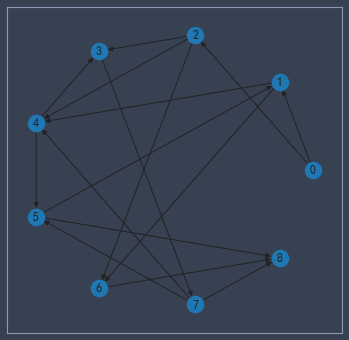

In [3]:
data_folder = 'data'
network_diagram1_path = os.path.join(data_folder, 'diagram1.csv')

custom_net = NetFlow(network_diagram1_path)
plt.figure(figsize=(6, 6))
custom_net.draw()

In [4]:
np.random.seed(233)
time_table = np.random.random(9) * 5

num = 10
samples = custom_net.sample(num, {0:0.5, 4:0.5}, 15)
print(time_table)
np.random.seed(233)
samples_set = [samples[np.random.randint(0, num)].copy() for i in range(num * 10)]
samples_set[:10]

[0.747 4.461 2.916 4.499 1.745 0.742 0.592 2.133 3.628]


[[0, 2, 3, 7, 8],
 [0, 2, 3, 7, 8],
 [0, 1, 6, 8],
 [4, 3, 7, 8],
 [0, 1, 6, 8],
 [0, 1, 6, 8],
 [4, 3, 7, 8],
 [0, 1, 6, 8],
 [0, 2, 6, 8],
 [0, 2, 3, 7, 8]]

In [5]:
# tasks[:10], tasks_done[:10], t_seqs[:11]

# Benchmark

先到先得

In [6]:
def init_head_tasks(samples):
    head_tasks = {node_id:[] for node_id in custom_net.nodes_id}
    for i, sample in enumerate(samples):
        head_tasks[sample[0]].append(i)
    return head_tasks
        
def time_first_strategy(samples, time_table):
    def get_new_task(tasks):
        has_task = False
#         origin_head_tasks = {k:v.copy() for k, v in head_tasks.items()}
        ## be careful that head_tasks will change as each keys' value is a list
        for node_id, rows in head_tasks.items():
            if rows:
                has_task = True
                if node_id not in tasks[-1]:
                    tasks[-1].append(node_id)
                    if temp_new_task != None:
                        temp_new_task.append(node_id)
        return has_task
    
    def add_next_head_tasks_when_done():
        for node_id in tasks_done[-1]:
            row = head_tasks[node_id].pop(0)
            samples[row].pop(0)
            # first come first do principle
            if not len(samples[row]):
                flows[row] = t_seqs[-1]
                continue 
            
            new_node_id = samples[row][0]
            insert_front(row, head_tasks[new_node_id])
                
    t = 0
    flows = {}
    tasks, tasks_done, t_seqs = [[]], [[]], [0]
    head_tasks = init_head_tasks(samples)
    temp_new_task = None
    
    while get_new_task(tasks):
        last_tasks =  tasks[-1]
        last_tasks_time = time_table[last_tasks] if t == 0 else np.hstack([last_tasks_time, 
                                                                           time_table[temp_new_task]])
        last_tasks_min_idx = last_tasks_time.argmin()
        
        last_tasks_min_time = last_tasks_time[last_tasks_min_idx]
        min_task_id = last_tasks[last_tasks_min_idx]
        # now we done, there may be some problem if two task have the same process time
        tasks_done.append([])
        tasks.append([])
        for task in last_tasks:
            tasks_done[-1].append(task) if task == min_task_id else tasks[-1].append(task)

        last_tasks_time = last_tasks_time[last_tasks_time != last_tasks_min_time] - last_tasks_min_time
        
        temp_new_task = []
        t += last_tasks_min_time
        
        t_seqs.append(t)
        add_next_head_tasks_when_done()
        
    return (flows, tasks[:-1], np.array(t_seqs), tasks_done[1:])
    
np.random.seed(233)
size = num * 100
samples_set = [samples[np.random.randint(0, 10)].copy() for i in range(size)]

flows, tasks, t_seqs, tasks_done = time_first_strategy(samples_set, time_table)

In [7]:
def get_flatten_ls(multi_dls):
    return [num for one_dls in multi_dls for num in one_dls]
flatten_tasks_done = get_flatten_ls(tasks_done)

len(tasks_done), len(tasks), len(t_seqs)

(4481, 4481, 4482)

In [8]:
points_num = len(t_seqs)
all_node_id = set(custom_net.nodes_id)
tasks_time_seqs = np.array([np.zeros(points_num) for _ in all_node_id])
t_diff = t_seqs[1:] - t_seqs[:-1]

for i in range(1, points_num):
    tasks_set = set(tasks[i-1])
    for node_id in tasks_set:
        tasks_time_seqs[node_id][i] = t_diff[i-1] + tasks_time_seqs[node_id][i-1]
    for other_node_id in (all_node_id - tasks_set):
        tasks_time_seqs[other_node_id][i] = tasks_time_seqs[other_node_id][i-1]
        
diff_tasks_time_seqs = tasks_time_seqs.copy()
diff_tasks_time_seqs[:, 1:] = tasks_time_seqs[:, 1:] - tasks_time_seqs[:, :-1]

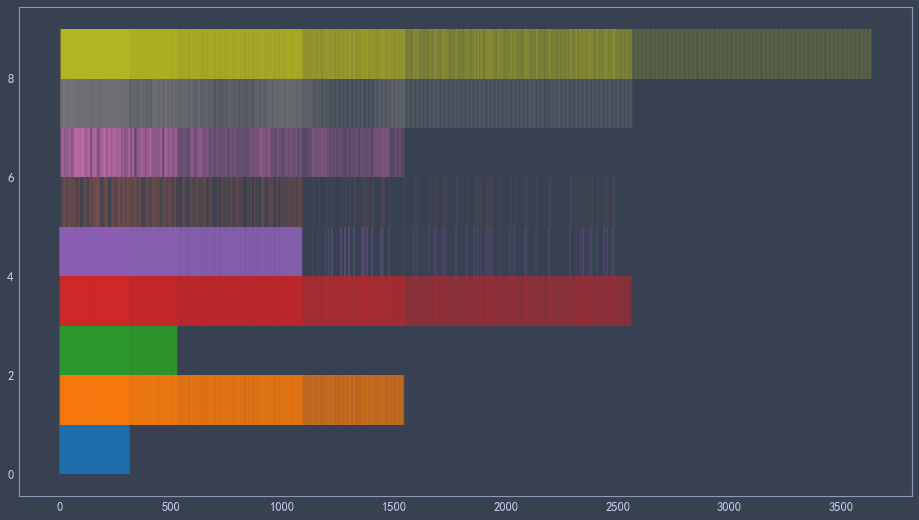

In [9]:
# plt.plot(t_seqs, diff_tasks_time_seqs[0])
plt.figure(figsize=(16, 9))

colors = plt.get_cmap('tab20').colors
for node_id in all_node_id:
    idxs = np.where(diff_tasks_time_seqs[node_id]>0)[0]
    plt.vlines(t_seqs[idxs], node_id, node_id+1, color=colors[node_id*2], lw=0.2)
# (t_seqs[idxs] + t_seqs[idxs-1])

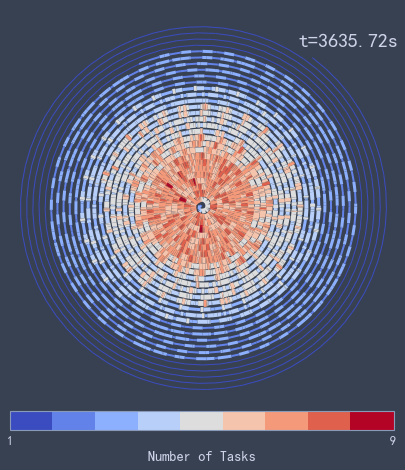

In [292]:
from matplotlib import collections, colors, transforms
fig, ax = plt.subplots(figsize=(6, 7))
r = 0.1 * t_seqs ** 0.5
# nverts = len(r)
# theta = np.array(range(nverts)) * (2*np.pi)/(nverts-1)
theta = 10*np.pi*r
yy = r * np.sin(theta)
xx = r * np.cos(theta)
spiral = np.vstack([xx,yy]).T
spiral = [spiral[[i, i+1],:] for i in range(t_seqs.size-1)]

lw = (diff_tasks_time_seqs[:, 1:] != 0).sum(axis=0)
colors = [cm.coolwarm(w/9) for w in lw]
collection = LineCollection(spiral, linewidths=lw, cmap=plt.cm.get_cmap('coolwarm', 9))
collection.set_array(lw)

ax.add_collection(collection)
ax.axis('equal')
fig.colorbar(collection, ticks=[1, 9], 
             label='Number of Tasks', orientation="horizontal", pad=0.01)

ax.text(2*xx[-1]-xx[-2], 2*yy[-1]-yy[-2], f"t={t_seqs[-1]:.2f}s")

x_max, y_max = xx.max()+0.1, yy.max()+0.1
ax.set_xlim(-x_max, x_max)
ax.set_ylim(-y_max, y_max)
ax.set_axis_off()
fig.tight_layout()
# plt.savefig('graph/spiral_plot.png', dpi=300,  bbox_inches='tight')

In [388]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def colormap_idx(cmap, idx):
    return ListedColormap(cmap(idx))

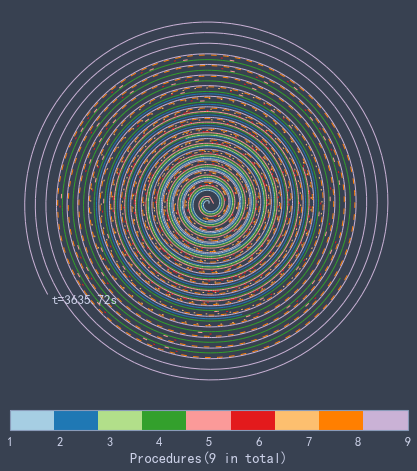

In [397]:
fig, ax = plt.subplots(figsize=(6, 7))
color_name = 'Paired'
colors = plt.get_cmap(color_name).colors
r = 0.1 * t_seqs ** 0.5 
theta =5.5*np.pi*r
for node_id in all_node_id:
    yy = (r+node_id*0.04) * np.sin(theta)
    xx = (r+node_id*0.04) * np.cos(theta)
    spiral = np.vstack([xx,yy]).T
    spiral = [spiral[[i, i+1],:] for i in range(t_seqs.size-1)]

    lw = (diff_tasks_time_seqs[node_id, 1:] != 0)
    collection = LineCollection(spiral, linewidths=lw, colors=colors[node_id])

    collections = ax.add_collection(collection)
ax.axis('equal')

sm = plt.cm.ScalarMappable(cmap=colormap_idx(plt.get_cmap(color_name), np.array(range(9))), 
                           norm=Normalize(1, 9)) 
sm.set_array([])
plt.colorbar(sm, pad=0.02, 
             label=f"Procedures({custom_net.node_num} in total)", orientation="horizontal") 


ax.text(2*xx[-1]-xx[-2], 2*yy[-1]-yy[-2], f"t={t_seqs[-1]:.2f}s")

x_max, y_max = xx.max()+0.2, yy.max()+0.2
ax.set_xlim(-x_max, x_max)
ax.set_ylim(-y_max, y_max)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('graph/spiral_plot_all_tasks.png', dpi=400,  bbox_inches='tight')

(-2.5, 2.5)

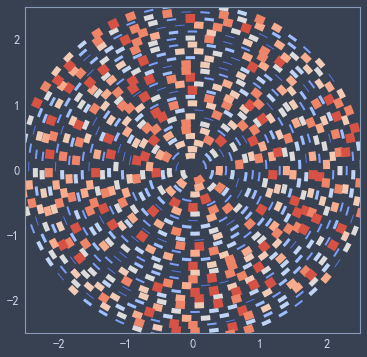

In [208]:
from matplotlib.collections import LineCollection
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(6, 6))
r = 1.5 * np.arange(0.01, 3, 0.001) ** 0.5
# nverts = len(r)
# theta = np.array(range(nverts)) * (2*np.pi)/(nverts-1)
theta = 20*np.pi*r
yy = r * np.sin(theta)
xx = r * np.cos(theta)
spiral = np.vstack([xx,yy])
spiral = [spiral[:, 0+i*4:3+i*4].T for i in range(1000)]


lw = np.random.randint(1, 10, 200)
colors = [cm.coolwarm(w/10) for w in lw]
collection = LineCollection(spiral, linewidths=lw, colors=colors)
# collection.set_color(plt.rcParams['axes.prop_cycle'].by_key()['color'][:1])
ax.add_collection(collection)
# ax.axis('equal')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

# fig, ax = plt.subplots(subplot_kw=dict(polar=True, facecolor='none'), figsize=(8, 8))
# r = (np.arange(0, 3.4**2, 0.01) ** 0.5)[2:]
# theta = 2*np.pi*r
# ax.set_axis_off()
# # ax.grid(False)
# # ax.axes.get_xaxis().set_visible(False)
# # ax.axes.get_yaxis().set_visible(False)
# start = np.arange(0, 300, 5)
# for start, end in zip(start, start + 3):
#     plt.fill_between(theta[[start,end]], r[[start,end]], (r+0.2)[[start,end]])

## Test's the correctness of result

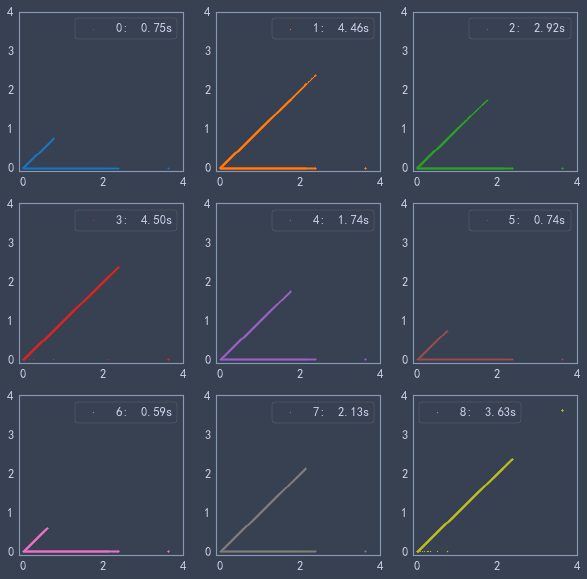

In [245]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

colors = plt.get_cmap('tab20').colors
for node_id, ax in zip(custom_net.nodes_id, axes.flat):
    ax.scatter(t_diff, diff_tasks_time_seqs[node_id, 1:], s=1, 
               color=colors[node_id*2], label=f"{node_id}:  {time_table[node_id]:.2f}s")
    ax.set_ylim(-0.1, 4)
    ax.set_xlim(-0.1, 4)
    ax.legend()

In [123]:
np.random.seed(233)
samples_set = [samples[np.random.randint(0, 10)].copy() for i in range(num * 100)]
count_result = count_samples(samples_set)

print(tasks_time_seqs[:, -1] / time_table)
print(count_result)

[417.000 345.000 180.000 569.000 676.000 296.000 429.000 569.000 1000.000]
Counter({8: 1000, 4: 676, 3: 569, 7: 569, 6: 429, 0: 417, 1: 345, 5: 296, 2: 180})


## Draw

In [124]:
count_dict = dict(sorted(count_result.items()))
(np.array(list(count_dict.values()))  * time_table).argsort()
# 排序与画图上面不同颜色线高低一致，说明线段高低代表总的时常

array([5, 6, 0, 2, 4, 7, 1, 3, 8], dtype=int64)

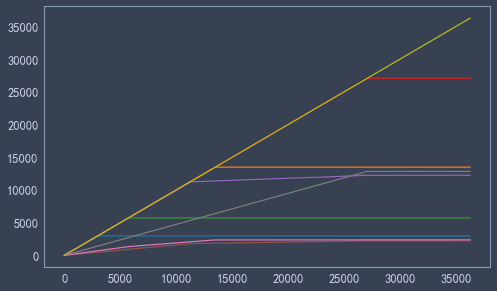

In [246]:
# 从整个完成时间看斜率不同，但从一段比较小的时间看，其实只是y=x与水平线的平均导致的结果
for node_id in custom_net.nodes_id:
    plt.plot(t_seqs, tasks_time_seqs[node_id], color=colors[node_id * 2])

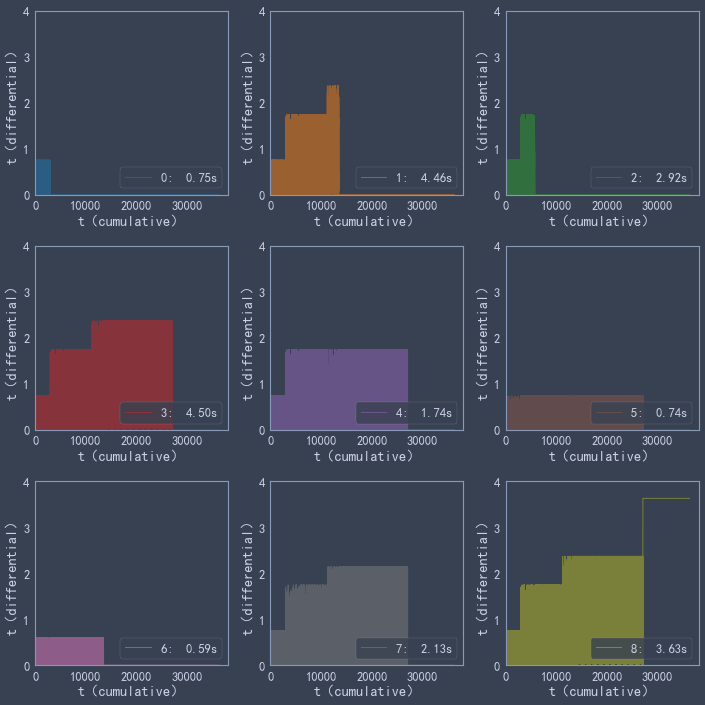

In [247]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

colors = plt.get_cmap('tab20').colors
for node_id, ax in zip(all_node_id, axes.flat):
    ax.plot(t_seqs, diff_tasks_time_seqs[node_id], 
             alpha=0.5, linewidth=1,
            label=f"{node_id}:  {time_table[node_id]:.2f}s", color=colors[node_id*2])
    ax.legend(loc="lower right")
    
    ax.set_xlabel('t（cumulative）')
    ax.set_ylabel("t（differential）")
    ax.set_ylim(0, 4)
    ax.set_xlim(0)
plt.tight_layout()

# plt.savefig(fname=f"graph/{custom_net.node_num}步骤运行时间矩阵", dpi=300)

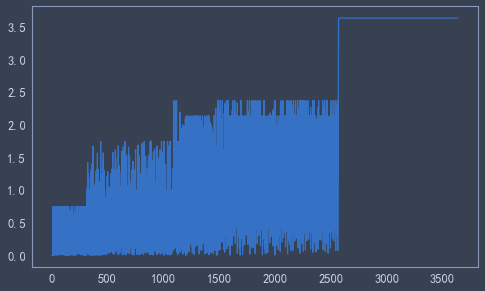

In [191]:
plt.plot(t_seqs, diff_tasks_time_seqs[8], label=f"{node_id}:  {time_table[node_id]:.2f}s")

(0.0, 3817.372368761183)

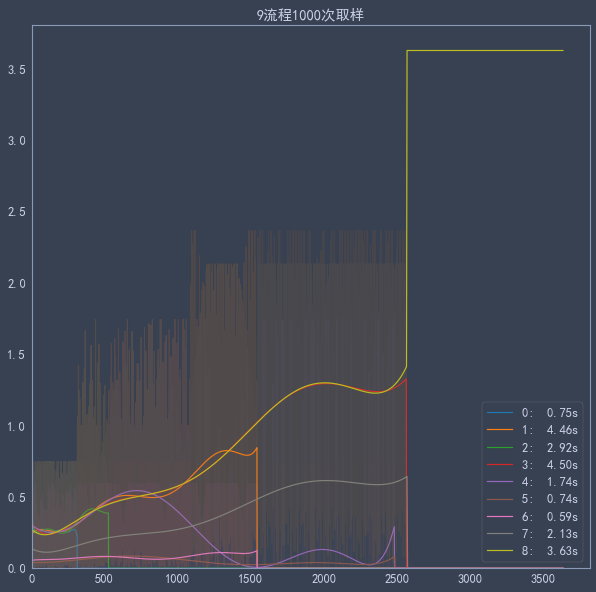

In [192]:
colors = plt.get_cmap('tab20').colors
plt.figure(figsize=(10, 10))
for node_id in list(all_node_id):
    color = colors[node_id * 2]
    exclude_idxs = diff_tasks_time_seqs[node_id].cumsum().argmax() + 3 if node_id != 8 else \
                    np.around(diff_tasks_time_seqs[node_id], 4).argmax()
    
    weight = np.polyfit(t_seqs[:exclude_idxs], diff_tasks_time_seqs[node_id][:exclude_idxs], 7)
    fit_diff_tasks_time_seqs = np.poly1d(weight)(t_seqs[:exclude_idxs])
    plt.plot(t_seqs, np.hstack([fit_diff_tasks_time_seqs, diff_tasks_time_seqs[node_id][exclude_idxs:]]), 
            label=f"{node_id}:  {time_table[node_id]:.2f}s", color=color) 
    plt.plot(t_seqs, diff_tasks_time_seqs[node_id], alpha=0.05, color=color)

title = f"{custom_net.node_num}流程{size}次取样"
plt.title(title)
plt.legend(loc="lower right")
plt.ylim(0, )
plt.xlim(0,)
# plt.savefig(fname=f"graph/{title}", dpi=200)

In [393]:
# test = {0:[], 1:[]}
# test[0].append(1)
# test
test = np.array([1.8, 1.2, 1.1, 5])
# test -= 1.1
np.hstack([test, test])

array([1.800, 1.200, 1.100, 5.000, 1.800, 1.200, 1.100, 5.000])

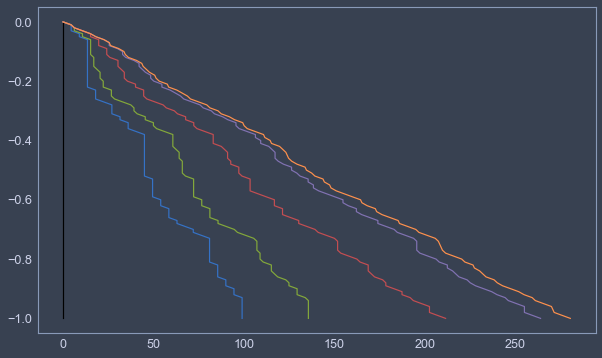

In [261]:
np.random.seed(233)
size = 100
time_axis = np.linspace(0, 1, size+1)
init_time_seq = np.zeros(size+1)

time_table = np.random.random(5) * 5
nodes_id = np.array(range(5))
nodes_id_seq = np.random.choice(nodes_id, size=size)

nodes_id_by_idxs, first_idxs = np.unique(nodes_id_seq, return_index=True)
sorted_nodes_id = nodes_id_by_idxs[np.argsort(first_idxs)]

plt.figure(figsize=(10, 6))
time_cumsum = init_time_seq.copy()
plt.plot(time_cumsum, -time_axis, color='black')
for node_id in sorted_nodes_id:
    time_seq = init_time_seq.copy()
    time_seq[np.where(nodes_id_seq == node_id)[0] + 1] = time_table[node_id]
    time_cumsum += time_seq.cumsum()
    plt.plot(time_cumsum, -time_axis)

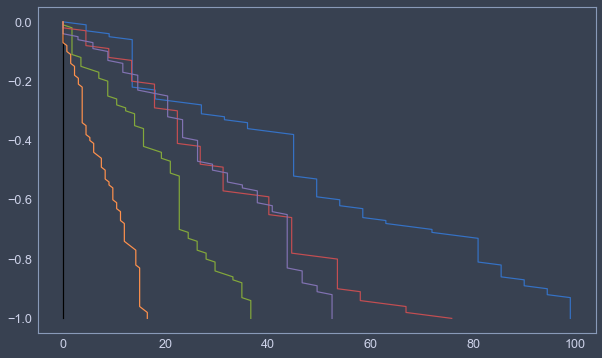

In [265]:
plt.figure(figsize=(10, 6))
time_cumsum = init_time_seq.copy()
plt.plot(time_cumsum, -time_axis, color='black')
for node_id in sorted_nodes_id:
    time_seq = init_time_seq.copy()
    time_seq[np.where(nodes_id_seq == node_id)[0] + 1] = time_table[node_id]
    time_cumsum += time_seq.cumsum()
    plt.plot(time_seq.cumsum(), -time_axis)

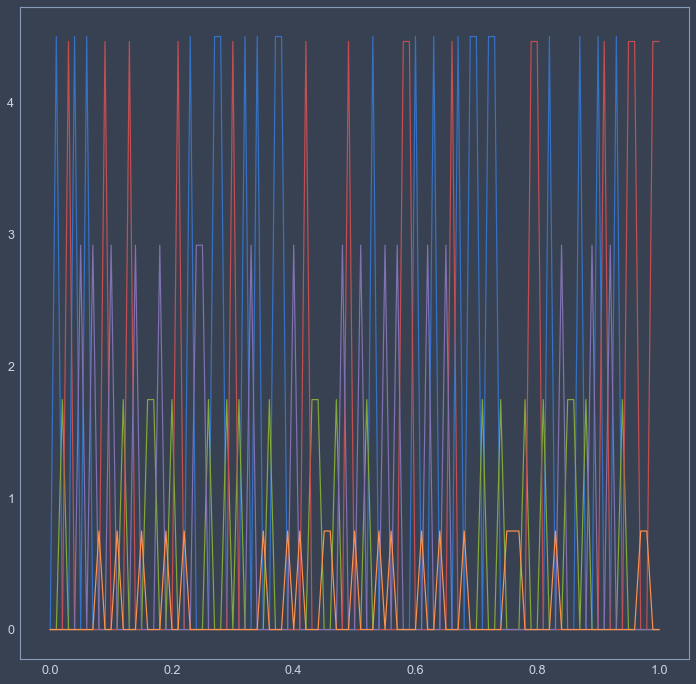

In [262]:
plt.figure(figsize=(12, 12))
time_cumsum = init_time_seq.copy()
# plt.plot(time_cumsum, -time_axis, color='black')
for node_id in sorted_nodes_id:
    time_seq = init_time_seq.copy()
    time_seq[np.where(nodes_id_seq == node_id)[0] + 1] = time_table[node_id]
    time_cumsum += time_seq.cumsum()
    plt.plot(time_axis, time_seq)

In [237]:
sorted_nodes_id, time_table

(array([3, 4, 1, 2, 0]), array([0.747, 4.461, 2.916, 4.499, 1.745]))

In [ ]:
np.array([1,2,3,0])

In [48]:
data_folder = 'data'
network_diagram1_path = os.path.join(data_folder, 'diagram1.csv')

graph_data = genfromtxt(network_diagram1_path, delimiter=',', dtype='int')
node_id = np.unique(graph_data)
node_num = len(node_id)

In [49]:
graph_matrix = np.zeros((node_num, node_num))

row_id, col_id = (graph_data - 1).T
graph_matrix[row_id, col_id] = 1

row_sum = graph_matrix.sum(axis=1)[:, None]
graph_matrix = np.divide(graph_matrix, row_sum, where=row_sum!=0)
print(graph_matrix)

[[0.000 0.500 0.500 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.500 0.000 0.500 0.000 0.000]
 [0.000 0.000 0.000 0.333 0.333 0.000 0.333 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 0.500 0.000 0.500 0.000 0.000 0.000]
 [0.000 0.500 0.000 0.000 0.000 0.000 0.000 0.000 0.500]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000]
 [0.000 0.000 0.000 0.000 0.333 0.333 0.000 0.000 0.333]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]


In [45]:
list(zip(*bag.items()))

[(0, 1, 2), (0.2, 0.6, 0.2)]

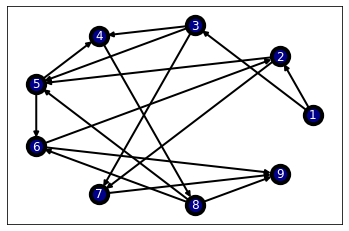

In [60]:
G = nx.DiGraph()
G.add_nodes_from(node_id)
G.add_edges_from(graph_data.tolist())
pos = nx.circular_layout(G)
#  neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp, unflatten.
options = {
    "font_size": 12,
    "font_color": 'white',
    "node_size": 300,
    "node_color": "darkblue",
    "edgecolors": "black",
    "linewidths": 4,
    "width": 2,
}

nx.draw_networkx(G, pos=pos, **options)